In [1]:
import sys
import numpy as np

from collections import defaultdict
from dahuffman import HuffmanCodec
from markovchain import MarkovChain
from sklearn import svm
from matplotlib import pyplot as plt

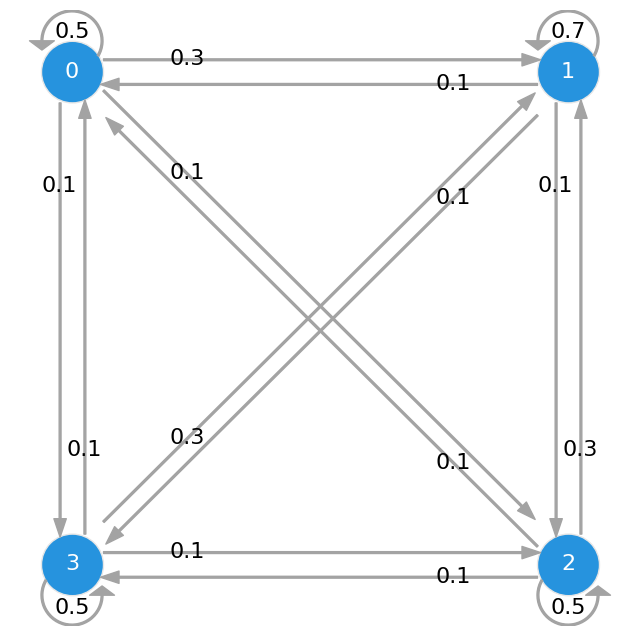

In [2]:
# markov chain with transition probabilities equal 
"""
p = np.array([
    [0.5, 0.3, 0.1, 0.1],
    [0.1, 0.7, 0.1, 0.1],
    [0.1, 0.3, 0.5, 0.1],
    [0.1, 0.3, 0.1, 0.5]
])
"""
p = np.identity(4) * 4 + np.ones((4, 4))
p[:, 1] += 2
# normalize
p /= 10


mc = MarkovChain(p, [str(i) for i in range(len(p))])
mc.draw()

In [3]:
def generate_sample(length):
    # generate an example using the Markov chain
    sample = [np.random.choice(range(4))]
    for _ in range(length):
        sample.append(np.random.choice(range(4), p=p[sample[-1]]))
    return sample[1:]

In [4]:
"""
Part 1: Basic SVM model on generated data
"""

NUM_TRAIN_SAMPLES = 9000
NUM_TEST_SAMPLES = 1000
SEQUENCE_LENGTH = 10

# task is to predict the next digit given the previous one
# generate sequences of length 10, e.g., (x1, x2, ... x10)
# label is the most frequent digit
train_x, train_y = [], []
for i in range(NUM_TRAIN_SAMPLES):
    sample = generate_sample(SEQUENCE_LENGTH) 
    train_x.append(sample)
    train_y.append(np.bincount(sample).argmax())

test_x, test_y = [], []
for i in range(NUM_TEST_SAMPLES):
    sample = generate_sample(SEQUENCE_LENGTH)
    test_x.append(sample)
    test_y.append(np.bincount(sample).argmax())


In [5]:
clf = svm.SVC()
clf.fit(train_x, train_y)

SVC()

In [6]:
print("SVM Accuracy on Uncompressed Data: ", np.sum(clf.predict(test_x) == test_y) / NUM_TEST_SAMPLES)

SVM Accuracy on Uncompressed Data:  0.884


In [7]:
"""
Part 2: Training SVM model on compressed data
"""
freq = defaultdict(int)
for example in train_x:
    for i in example:
        freq[i] += 1
codec = HuffmanCodec.from_data(freq)

In [8]:
def compress_to_bit_arr(x):
    #compresses a string with our Codec and returns a bit array
    return [int(digit) for digit in bin(int.from_bytes(x, byteorder=sys.byteorder))[2:]]

def bitstring_to_bytes(s):
    # citation: https://stackoverflow.com/questions/32675679/convert-binary-string-to-bytearray-in-python-3
    s = "".join([str(bit) for bit in s])
    v = int(s, 2)
    b = bytearray()
    while v:
        b.append(v & 0xff)
        v >>= 8
    return bytes(b)

# sanity check
for x in train_x[:10]:
    x = codec.encode(x)
    assert(x == bitstring_to_bytes(compress_to_bit_arr(x)))

In [9]:
compressed_train_x = [compress_to_bit_arr(codec.encode(example)) for example in train_x]
max_length = max([len(x) for x in compressed_train_x])
# padding to prevent jagged arrays
for elem in compressed_train_x:
    while(len(elem) < max_length):
        elem.append(-1)

compressed_test_x = [compress_to_bit_arr(codec.encode(example)) for example in test_x]
# padding to prevent jagged arrays
for elem in compressed_test_x:
    while(len(elem) < max_length):
        elem.append(-1)


compressed_clf = svm.SVC()
compressed_clf.fit(compressed_train_x, train_y)

SVC()

In [10]:
print("SVM Accuracy on Uncompressed Data: ", np.sum(compressed_clf.predict(compressed_test_x) == test_y) / NUM_TEST_SAMPLES)

SVM Accuracy on Uncompressed Data:  0.858


In [11]:
"""
Part 3: Comparing results for various sequence lengths
"""
uncompressed_acc, compressed_acc = [], []

lengths = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

for seq_length in lengths:
    train_x, train_y = [], []
    for i in range(NUM_TRAIN_SAMPLES):
        sample = generate_sample(SEQUENCE_LENGTH) 
        train_x.append(sample)
        train_y.append(np.bincount(sample).argmax())

    test_x, test_y = [], []
    for i in range(NUM_TEST_SAMPLES):
        sample = generate_sample(SEQUENCE_LENGTH)
        test_x.append(sample)
        test_y.append(np.bincount(sample).argmax())
    clf = svm.SVC()
    clf.fit(train_x, train_y)
    
    uncompressed_acc.append(np.sum(clf.predict(test_x) == test_y) / NUM_TEST_SAMPLES)

    freq = defaultdict(int)
    for example in train_x:
        for i in example:
            freq[i] += 1
    codec = HuffmanCodec.from_data(freq)

    compressed_train_x = [compress_to_bit_arr(codec.encode(example)) for example in train_x]
    max_length = max([len(x) for x in compressed_train_x])
    # padding to prevent jagged arrays
    for elem in compressed_train_x:
        while(len(elem) < max_length):
            elem.append(-1)

    compressed_test_x = [compress_to_bit_arr(codec.encode(example)) for example in test_x]
    # padding to prevent jagged arrays
    for elem in compressed_test_x:
        while(len(elem) < max_length):
            elem.append(-1)

    compressed_clf = svm.SVC()
    compressed_clf.fit(compressed_train_x, train_y)

    compressed_acc.append(np.sum(compressed_clf.predict(compressed_test_x) == test_y) / NUM_TEST_SAMPLES)

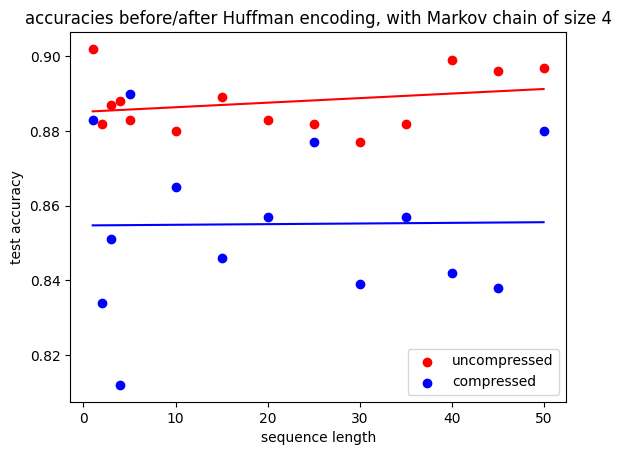

In [15]:
plt.scatter(lengths, uncompressed_acc, label="uncompressed", color="r")
plt.scatter(lengths, compressed_acc, label="compressed", color="b")
plt.plot(lengths, np.poly1d(np.polyfit(lengths, uncompressed_acc, 1))(lengths), color="r")
plt.plot(lengths, np.poly1d(np.polyfit(lengths, compressed_acc, 1))(lengths), color="b")
plt.title("accuracies before/after Huffman encoding, with Markov chain of size 4")
plt.xlabel("sequence length")
plt.ylabel("test accuracy")
plt.legend()
plt.show()